In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 필요 library 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

import pickle

In [4]:
# data 경로 설정 
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
data = pd.read_csv(root+"/timeseries_transform.csv")
data

,time,zone,n_drive,n_drive_unique
0,2019-01-01 00:00:00,0,12.0,12.0
1,2019-01-01 00:00:00,1,1.0,1.0
2,2019-01-01 00:00:00,2,5.0,5.0
3,2019-01-01 00:00:00,3,3.0,3.0
4,2019-01-01 00:00:00,4,2.0,2.0
...,...,...,...,...
3519019,2019-11-30 23:00:00,434,0.0,0.0
3519020,2019-11-30 23:00:00,435,0.0,0.0
3519021,2019-11-30 23:00:00,436,0.0,0.0
3519022,2019-11-30 23:00:00,437,0.0,0.0


In [5]:
timeseries = data.drop(["n_drive"],1)
timeseries

,time,zone,n_drive_unique
0,2019-01-01 00:00:00,0,12.0
1,2019-01-01 00:00:00,1,1.0
2,2019-01-01 00:00:00,2,5.0
3,2019-01-01 00:00:00,3,3.0
4,2019-01-01 00:00:00,4,2.0
...,...,...,...
3519019,2019-11-30 23:00:00,434,0.0
3519020,2019-11-30 23:00:00,435,0.0
3519021,2019-11-30 23:00:00,436,0.0
3519022,2019-11-30 23:00:00,437,0.0


In [6]:
# 시계열 데이터 1일 단위로 resampling
timeseries["time"] = pd.to_datetime(timeseries["time"])
ts=timeseries
ts=ts.set_index('time')
ts_resample= pd.DataFrame()
ts_resample['n_drive_1day'] = ts.groupby('zone').n_drive_unique.resample('1D').max()
ts_resample.reset_index(inplace = True)
ts_resample

,zone,time,n_drive_1day
0,0,2019-01-01,15.0
1,0,2019-01-02,7.0
2,0,2019-01-03,14.0
3,0,2019-01-04,15.0
4,0,2019-01-05,17.0
...,...,...,...
146621,438,2019-11-26,0.0
146622,438,2019-11-27,0.0
146623,438,2019-11-28,0.0
146624,438,2019-11-29,0.0


In [7]:
# feature값 추가 : 요일 data
week = list()
for i in range(len(ts_resample)):
  week.append(ts_resample['time'][i].weekday())
ts_resample['week'] = week

ts_resample

,zone,time,n_drive_1day,week
0,0,2019-01-01,15.0,1
1,0,2019-01-02,7.0,2
2,0,2019-01-03,14.0,3
3,0,2019-01-04,15.0,4
4,0,2019-01-05,17.0,5
...,...,...,...,...
146621,438,2019-11-26,0.0,1
146622,438,2019-11-27,0.0,2
146623,438,2019-11-28,0.0,3
146624,438,2019-11-29,0.0,4


In [8]:
# onehot encoding (요일값)
ts_resample = pd.get_dummies(ts_resample, columns=['week'])
ts_resample.head()

,zone,time,n_drive_1day,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,0,2019-01-01,15.0,0,1,0,0,0,0,0
1,0,2019-01-02,7.0,0,0,1,0,0,0,0
2,0,2019-01-03,14.0,0,0,0,1,0,0,0
3,0,2019-01-04,15.0,0,0,0,0,1,0,0
4,0,2019-01-05,17.0,0,0,0,0,0,1,0


In [9]:
# 시계열 데이터에서 이전 시점 데이터 lagging하여 feature값으로 추가
for i in range(56):
  ts_resample[f'lag{i+1}'] = ts_resample.groupby(['zone'])['n_drive_1day'].shift(i+7)
ts_resample[54:60]

,zone,time,n_drive_1day,week_0,week_1,week_2,week_3,week_4,week_5,week_6,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56
54,0,2019-02-24,25.0,0,0,0,0,0,0,1,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,0,2019-02-25,20.0,1,0,0,0,0,0,0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,0,2019-02-26,26.0,0,1,0,0,0,0,0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
57,0,2019-02-27,20.0,0,0,1,0,0,0,0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0,NaN,NaN,NaN,NaN,NaN
58,0,2019-02-28,22.0,0,0,0,1,0,0,0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0,NaN,NaN,NaN,NaN
59,0,2019-03-01,31.0,0,0,0,0,1,0,0,18.0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0,NaN,NaN,NaN


In [10]:
# 결측값 포함 행 제거
ts_sample = ts_resample.dropna()
ts_sample.head()

,zone,time,n_drive_1day,week_0,week_1,week_2,week_3,week_4,week_5,week_6,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56
62,0,2019-03-04,12.0,1,0,0,0,0,0,0,20.0,25.0,19.0,18.0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0,15.0
63,0,2019-03-05,19.0,0,1,0,0,0,0,0,26.0,20.0,25.0,19.0,18.0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0,7.0
64,0,2019-03-06,21.0,0,0,1,0,0,0,0,20.0,26.0,20.0,25.0,19.0,18.0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0,14.0
65,0,2019-03-07,36.0,0,0,0,1,0,0,0,22.0,20.0,26.0,20.0,25.0,19.0,18.0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0,15.0
66,0,2019-03-08,29.0,0,0,0,0,1,0,0,31.0,22.0,20.0,26.0,20.0,25.0,19.0,18.0,20.0,26.0,17.0,17.0,19.0,28.0,17.0,12.0,19.0,19.0,17.0,15.0,17.0,12.0,14.0,21.0,47.0,41.0,27.0,25.0,17.0,23.0,23.0,17.0,14.0,13.0,20.0,13.0,13.0,15.0,15.0,14.0,15.0,15.0,14.0,13.0,18.0,15.0,11.0,16.0,21.0,14.0,11.0,8.0,17.0,10.0,14.0,17.0


In [11]:
# DEVIDE값 : zone별 data갯수
DEVIDE = len(ts_sample)//len(set(ts_sample["zone"].unique()))
print(DEVIDE)
MSE = list()

split_num = round(DEVIDE*0.8)

# zone별 GradienBoostingRegressor이용하여 mse값 측정
for i in range(len(ts_sample)//DEVIDE):
  d_sample = ts_sample[DEVIDE*i:DEVIDE*(i+1)]

  train = d_sample[:split_num]
  test = d_sample[split_num:]
  x_train = np.asarray(train.drop(['n_drive_1day','time'],1))
  y_train = np.asarray(train['n_drive_1day'])
  x_test = np.asarray(test.drop(['n_drive_1day','time'],1))
  y_test = np.asarray(test['n_drive_1day'])

  reg = ensemble.GradientBoostingRegressor(n_estimators=200,max_depth=4,min_samples_leaf=1,learning_rate=0.05)
  reg.fit(x_train, y_train)

  
  # 최적의 parameter 탐색 (필요시 activation)
  '''
  X = np.concatenate((x_train,x_test), axis=0)
  y = np.concatenate((y_train,y_test), axis=0)

  param_grid = {'n_estimators': [200,300],
    'max_depth': [3, 4],
    'min_samples_leaf': [1, 20],
    'learning_rate': [0.02,0.05],
    'loss': ['ls']}

  pds = PredefinedSplit(test_fold=[-1]*len(x_train)+[0]*len(x_test))

  grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                    param_grid=param_grid, 
                    cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
  grid_search.fit(X, y)
  '''

  mse = mean_squared_error(y_test, np.round(reg.predict(x_test)))
  MSE.append(mse)

  globals()['model_{}'.format(i)] = reg

  if i % 50 == 0:
    print("zone{} , The mean squared error (MSE) on test set: {:.4f}".format(i,mse))

print()
print("MSE average : {:.4f}".format(sum(MSE)/len(MSE)))

272
zone0 , The mean squared error (MSE) on test set: 39.7593
zone50 , The mean squared error (MSE) on test set: 0.2037
zone100 , The mean squared error (MSE) on test set: 0.3889
zone150 , The mean squared error (MSE) on test set: 0.0926
zone200 , The mean squared error (MSE) on test set: 0.0926
zone250 , The mean squared error (MSE) on test set: 0.2593
zone300 , The mean squared error (MSE) on test set: 0.6481
zone350 , The mean squared error (MSE) on test set: 0.0000
zone400 , The mean squared error (MSE) on test set: 0.2222

MSE average : 0.9521


In [12]:
# 각 zone별 model을 pickle형태의 한 파일로 저장
import pickle
filename = "/content/drive/MyDrive/Colab Notebooks/data/socar_timeseries_models.sav"
modlist = list()
for i in range(len(ts_sample)//DEVIDE):
  modlist.append(globals()['model_{}'.format(i)])
s = pickle.dump(modlist, open(filename, 'wb'))

▼ zone0 실제값,예측값 비교



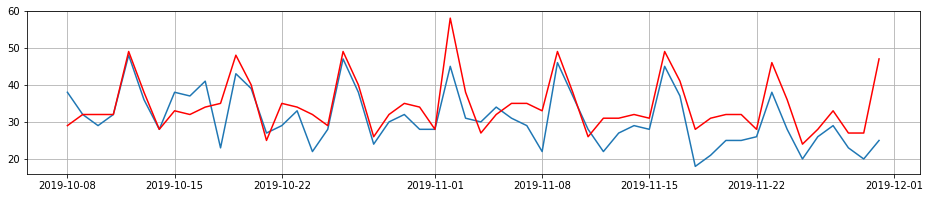


▼ zone1 실제값,예측값 비교



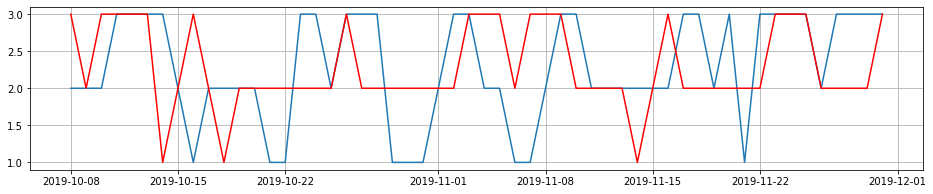

In [13]:
# Visualization (실제값,예측값 비교 plot)

for z in range(2):
# z = zone number
  print(f'▼ zone{z} 실제값,예측값 비교')
  print()
  d_sample = ts_sample[DEVIDE*z:DEVIDE*(z+1)]

  train = d_sample[:split_num]
  test = d_sample[split_num:]
  x_train = np.asarray(train.drop(['n_drive_1day','time'],1))
  y_train = np.asarray(train['n_drive_1day'])
  x_test = np.asarray(test.drop(['n_drive_1day','time'],1))
  y_test = np.asarray(test['n_drive_1day'])

  plt.figure(figsize=(16,3))
  plt.grid(True)
  X = test["time"]
  Y1 = y_test
  Y2 = np.round(globals()['model_{}'.format(z)].predict(x_test))
  plt.plot(X, Y1)
  plt.plot(X, Y2,color='r') # red line = 예측값
  plt.show()
  print()

In [ ]:
# Deviance(train,test 이탈값 확인)
z = 0
params={'n_estimators': 200}
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(globals()['model_{}'.format(z)].staged_predict(x_test)):
    test_score[i] = globals()['model_{}'.format(z)].loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, globals()['model_{}'.format(z)].train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

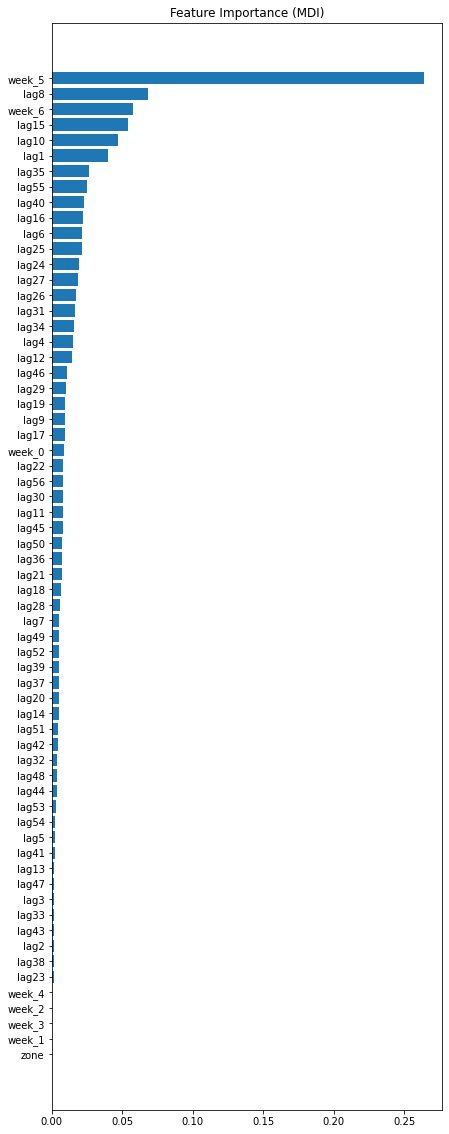

In [16]:
# Feature Importance 확인
z = 0
features = [x for i,x in enumerate(ts_sample) if not i in [1,2]]
feature_importance = globals()['model_{}'.format(z)].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(7,20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()